#**Capstone Project - Computer Vision**
## **Milestone 1**

### **DOMAIN:**
Automotive. Surveillance.
### **CONTEXT:**
Computer vision can be used to automate supervision and generate action appropriate action trigger if the event is
predicted from the image of interest. For example a car moving on the road can be easily identified by a camera as make of
the car, type, colour, number plates etc.
### **DATA DESCRIPTION:**
The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing
images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g.
2012 Tesla Model S or 2012 BMW M3 coupe.
#### **Data description:**
* **Train Images:** Consists of real images of cars as per the make and year of the 
car.
* **Test Images:** Consists of real images of cars as per the make and year of the car.
* **Train Annotation:** Consists of bounding box region for training images.
* **Test Annotation:** Consists of bounding box region for testing images.
Dataset has been attached along with this project. Please use the same for this capstone project.
<br>Original link to the dataset: https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder
<br>Reference: 3D Object Representations for Fine-Grained Categorisation, Jonathan Krause, Michael Stark, Jia Deng, Li Fei-Fei 4th IEEE
Workshop on 3D Representation and Recognition, at ICCV 2013 (3dRR-13). Sydney, Australia. Dec. 8, 2013.

### **OBJECTIVE:**
Design a DL based car identification model.

Importing Tensorflow Version

In [1]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.4.1'

Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Defining Project Path

In [3]:
project_path = '/content/drive/My Drive/AIML/Capstone project/'

Importing Necessary Libraries

In [4]:
import pandas as pd
import numpy as np
import os

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import model_from_json


# Initialize the random number generator
import random
random.seed(0)
# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

Mapping CSV file to Annotation



In [5]:
class_names_data = pd.read_csv(project_path+"names.csv", header=None, names=["class_name"])
train_annotate = pd.read_csv(project_path+"anno_train.csv", header=None, names=["image_file","x0","y0","x1","y1","class"])
test_annotate = pd.read_csv(project_path+"anno_test.csv", header=None, names=["image_file","x0","y0","x1","y1","class"])

In [6]:
#Showing Top 10 label of Class Name
class_names_data.head(10)

,class_name
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012
5,Acura Integra Type R 2001
6,Acura ZDX Hatchback 2012
7,Aston Martin V8 Vantage Convertible 2012
8,Aston Martin V8 Vantage Coupe 2012
9,Aston Martin Virage Convertible 2012


In [ ]:
#Showing Top 10 label of Train Annotation
train_annotate.head(10)

,image_file,x0,y0,x1,y1,class
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106
5,00006.jpg,259,289,515,416,123
6,00007.jpg,88,80,541,397,89
7,00008.jpg,73,79,591,410,96
8,00009.jpg,20,126,1269,771,167
9,00010.jpg,21,110,623,367,58


In [ ]:
#Showing Top 10 label of Test Annotation
test_annotate.head(10)

,image_file,x0,y0,x1,y1,class
0,00001.jpg,30,52,246,147,181
1,00002.jpg,100,19,576,203,103
2,00003.jpg,51,105,968,659,145
3,00004.jpg,67,84,581,407,187
4,00005.jpg,140,151,593,339,185
5,00006.jpg,20,77,420,301,78
6,00007.jpg,249,166,2324,1459,118
7,00008.jpg,119,215,1153,719,165
8,00009.jpg,1,7,275,183,32
9,00010.jpg,28,55,241,177,60


In [ ]:
#Showing Example of Class Name Which contains Make, Model, Type, Year
class_names_data['class_name'][195]

'smart fortwo Convertible 2012'

Mapping Class Name file and Train Annotation file




In [ ]:
train_annotate['class_name'] = train_annotate.apply(lambda x: class_names_data['class_name'][(x['class']-1)], axis=1)

In [ ]:
#Showing mapping train annotation file
train_annotate

,image_file,x0,y0,x1,y1,class,class_name
0,00001.jpg,39,116,569,375,14,Audi TTS Coupe 2012
1,00002.jpg,36,116,868,587,3,Acura TL Sedan 2012
2,00003.jpg,85,109,601,381,91,Dodge Dakota Club Cab 2007
3,00004.jpg,621,393,1484,1096,134,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,14,36,133,99,106,Ford F-450 Super Duty Crew Cab 2012
...,...,...,...,...,...,...,...
8139,08140.jpg,3,44,423,336,78,Chrysler Town and Country Minivan 2012
8140,08141.jpg,138,150,706,523,196,smart fortwo Convertible 2012
8141,08142.jpg,26,246,660,449,163,Mercedes-Benz SL-Class Coupe 2009
8142,08143.jpg,78,526,1489,908,112,Ford GT Coupe 2006


In [ ]:
train_annotate.iloc[10]

image_file                  00011.jpg
x0                                 51
y0                                 93
x1                                601
y1                                393
class                              49
class_name    Buick Verano Sedan 2012
Name: 10, dtype: object

Defining image path file list

In [7]:
def get_image_file_list(image_path):
  train_image_dir = os.listdir(image_path)
  train_image_list=[]
  for i in train_image_dir:
    for f in os.listdir(os.path.join(image_path, i)):
              # Check file extension. Allow only jpg/jpeg' files.
              ext = os.path.splitext(f)[1]
              if ext == '.jpg' or ext == '.jpeg':
                train_image_list.append("{}/{}".format(i,f))
  return train_image_list

Defining image path list

In [8]:
def map_image_metadata(image_base_path, annotate_metadata, image_path_list):
  image_path_lst_split = [i.split('/')[1] for i in image_path_list]
  annotate_metadata["car_image_path"] = annotate_metadata.apply(
      lambda row: image_base_path+'/'+ image_path_list[image_path_lst_split.index(row['image_file'])], 
      axis=1)
  return annotate_metadata

Mapping Training Annoatation and Image Path

In [ ]:
train_image_path = project_path+"car_data/car_data/train"
train_image_list = get_image_file_list(train_image_path)
train_annotate = map_image_metadata(train_image_path, train_annotate, train_image_list)

In [ ]:
train_annotate.head(11)

,image_file,x0,y0,x1,y1,class,class_name,car_image_path
0,00001.jpg,39,116,569,375,14,Audi TTS Coupe 2012,/content/drive/My Drive/AIML/Capstone project/...
1,00002.jpg,36,116,868,587,3,Acura TL Sedan 2012,/content/drive/My Drive/AIML/Capstone project/...
2,00003.jpg,85,109,601,381,91,Dodge Dakota Club Cab 2007,/content/drive/My Drive/AIML/Capstone project/...
3,00004.jpg,621,393,1484,1096,134,Hyundai Sonata Hybrid Sedan 2012,/content/drive/My Drive/AIML/Capstone project/...
4,00005.jpg,14,36,133,99,106,Ford F-450 Super Duty Crew Cab 2012,/content/drive/My Drive/AIML/Capstone project/...
5,00006.jpg,259,289,515,416,123,Geo Metro Convertible 1993,/content/drive/My Drive/AIML/Capstone project/...
6,00007.jpg,88,80,541,397,89,Dodge Journey SUV 2012,/content/drive/My Drive/AIML/Capstone project/...
7,00008.jpg,73,79,591,410,96,Dodge Charger Sedan 2012,/content/drive/My Drive/AIML/Capstone project/...
8,00009.jpg,20,126,1269,771,167,Mitsubishi Lancer Sedan 2012,/content/drive/My Drive/AIML/Capstone project/...
9,00010.jpg,21,110,623,367,58,Chevrolet Traverse SUV 2012,/content/drive/My Drive/AIML/Capstone project/...


Defining Show Image Function

In [ ]:
def show_image(metadata):
  img = cv2.imread(metadata['car_image_path'],1)
  plt.imshow(img)
  plt.show()

Defining Bounding Box function

In [ ]:
def show_image_with_bb(df):
  img = cv2.imread(df.car_image_path,1)
  x0=df.x0
  x1=df.x1
  y0=df.y0
  y1=df.y1

  fig, ax = plt.subplots(1)
  ax.imshow(img)
  rect = patches.Rectangle((x0,y0), (x1-x0),(y1-y0),
                          linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  plt.title(df.class_name)
  plt.show()

Printing Sample Train Image Metadata

In [ ]:
df = train_annotate.iloc[10]
df

image_file                                                00011.jpg
x0                                                               51
y0                                                               93
x1                                                              601
y1                                                              393
class                                                            49
class_name                                  Buick Verano Sedan 2012
car_image_path    /content/drive/My Drive/AIML/Capstone project/...
Name: 10, dtype: object

Showing Sample Train Image

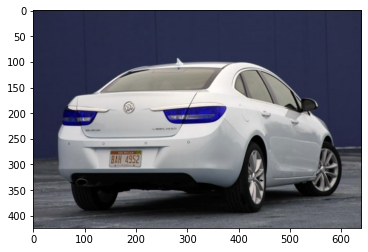

In [ ]:
show_image(df)

Showing Image with Bounding Box

In [ ]:
df['car_image_path']

'/content/drive/My Drive/AIML/Capstone project/car_data/car_data/train/Buick Verano Sedan 2012/00011.jpg'

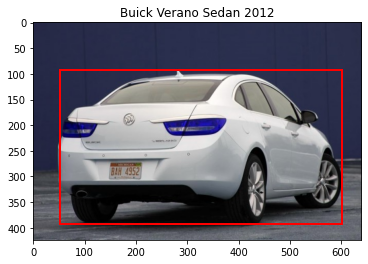

In [ ]:
show_image_with_bb(df)

Mapping Test Annotation file to Class Name

In [ ]:
test_annotate['class_name'] = test_annotate.apply(lambda x: class_names_data['class_name'][(x['class']-1)], axis=1)

In [ ]:
test_image_path = project_path+"car_data/car_data/test"
test_image_list = get_image_file_list(test_image_path)
test_annotate = map_image_metadata(test_image_path, test_annotate, test_image_list)

In [ ]:
df = test_annotate.iloc[10]
df

image_file                                                00011.jpg
x0                                                               30
y0                                                               20
x1                                                              438
y1                                                              253
class                                                            49
class_name                                  Buick Verano Sedan 2012
car_image_path    /content/drive/My Drive/AIML/Capstone project/...
Name: 10, dtype: object

Showing Sample Test Image

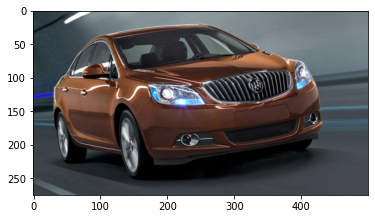

In [ ]:
show_image(df)

Showing Sample Test Image with Bounding Box

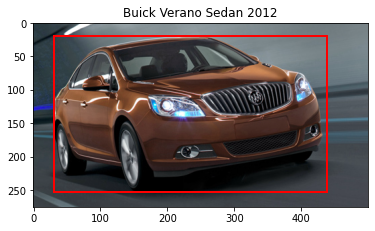

In [ ]:
show_image_with_bb(df)

In [9]:
ALPHA = 1

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 32
WIDTH_CELLS = 32

IMAGE_SIZE = 224

In [ ]:
img = cv2.imread(df['car_image_path'],1)

In [ ]:
img_resized = cv2.resize(img,(IMAGE_WIDTH,IMAGE_HEIGHT), interpolation = cv2.INTER_AREA)

In [ ]:
img = cv2.UMat(cv2.imread(df['car_image_path'],1))

In [ ]:
img.get().shape

(275, 500, 3)

In [ ]:
df.x1

438

Resizing the image to take them as input to mobilenet
* resizing all the input images to same size (in this case 224,244)
* resizing the boumding boxes to the normalized image size
* making the bounding box as height and width, instead of starting and ending points
* setting the class as target variables

In [10]:
def resize_image_data(annotate):
    resized_images = []
    images_bb = []
    images_class = []

    for index, rows in annotate.iterrows():
        img = cv2.UMat(cv2.imread(rows['car_image_path'],1)).get()
        img_resized = cv2.resize(img,(IMAGE_WIDTH,IMAGE_HEIGHT), interpolation = cv2.INTER_AREA)
        #geting the height and width for the bounding box
        img_hw = np.zeros((4,1), dtype=np.float32)

        img_hw[0] = rows['x0']*IMAGE_WIDTH/img.shape[1]
        img_hw[1] = rows['y0']*IMAGE_HEIGHT/img.shape[0]
        img_hw[2] = (rows['x1']-rows['x0'])*IMAGE_WIDTH/img.shape[1]
        img_hw[3] = (rows['y1']-rows['y0'])*IMAGE_HEIGHT/img.shape[0]

        images_bb.append(img_hw)
        resized_images.append(preprocess_input(np.array(img_resized, dtype=np.float32)))
        images_class.append(rows['class'])
        
        #print("Index:{}".format(index))
        #print(img_hw)
        del img, img_resized, img_hw

    return resized_images, images_bb, images_class

In [ ]:
train_images, train_bb, train_class = resize_image_data(train_annotate)

In [ ]:
len(train_images)

8144

In [ ]:
len(train_bb)

8144

In [11]:
data_path = "/content/drive/My Drive/AIML/Image_data_caps/"

In [ ]:
np.save(data_path+"train_images.npy",train_images)
np.save(data_path+"train_bb.npy", train_bb)
np.save(data_path+"train_classes.npy", train_class)

In [ ]:
train_images = np.load(data_path+"train_images.npy")
train_bb = np.load(data_path+"train_bb.npy")
train_class = np.load(data_path+"train_classes.npy")

In [ ]:
project_path

'/content/drive/My Drive/AIML/Capstone project/'

In [ ]:
test_images, test_bb, test_class = resize_image_data(test_annotate)

In [ ]:
len(test_images)

In [ ]:
data_path

'/content/drive/My Drive/AIML/Image_data_caps/'

In [ ]:
np.save(data_path+"test_images.npy",test_images)
np.save(data_path+"test_bb.npy", test_bb)
np.save(data_path+"test_classes.npy", test_class)

In [ ]:
test_images = np.load(data_path+"test_images.npy")
test_bb = np.load(data_path+"test_bb.npy")
test_class = np.load(data_path+"test_classes.npy")

In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten, Conv2D, Reshape, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

In [13]:
from keras.backend import sigmoid 
  
def swish(x, beta = 1): 
    return (x * sigmoid(beta * x)) 

In [ ]:
def create_classification_model(trainable=True):
    model = MobileNetV2(
            input_shape=(224,224,3), alpha=1.0, include_top=False, weights='imagenet',
            classifier_activation='softmax')

    for layer in model.layers:
        layer.trainable = trainable

    x=model.output
    x=Dropout(0.2)(x)
    x=BatchNormalization(epsilon=0.0001)(x)
    x=Flatten()(x)
    x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
    x=Dropout(0.3)(x)
    x=BatchNormalization(epsilon=0.0001)(x)
    x=Dense(1024,activation='swish')(x) #dense layer 2
    #x=Dense(512,activation='relu')(x) #dense layer 3
    x=Dense(196,activation='softmax')(x) #final layer with softmax activation

    return Model(inputs=model.input, outputs=x)

In [ ]:
def create_bb_model(trainable=True):
    model = MobileNetV2(
            input_shape=(224,224,3), alpha=1.0, include_top=False, weights='imagenet',
            classifier_activation='softmax')

    for layer in model.layers:
        layer.trainable = trainable

    x0 = model.layers[-1].output
    x1 = Conv2D(4, kernel_size=7, name="coords")(x0)
    x2 = Reshape((4,))(x1) # These are the 4 predicted coordinates of one BBox

    return Model(inputs=model.input, outputs=x2)

In [ ]:
def IOU(y_true, y_pred):
    intersections = 0
    unions = 0
    # set the types so we are sure what type we are using

    gt = y_true
    pred = y_pred
    # Compute interection of predicted (pred) and ground truth (gt) bounding boxes
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height

    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

    # Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
      if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
        intersections += intersection[j]
        unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + tensorflow.keras.backend.epsilon()), 4)
    # This must match the type used in py_func
    iou = iou.astype(np.float32)
    return iou

In [ ]:
def IoU(y_true, y_pred):
    iou = tensorflow.py_function(IOU, [y_true, y_pred], Tout=tensorflow.float32)
    return iou

In [ ]:
classification_model = create_classification_model(False)
classification_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________

In [ ]:
bb_model = create_bb_model(False) # Arg is False, if you want to freeze lower layers for fast training (but low accuracy)
bb_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
bb_model.compile(loss="mean_squared_error", optimizer="adam", metrics=[IoU]) # Regression loss is MSE

In [ ]:
classification_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics="accuracy")

In [ ]:
df = train_annotate.iloc[10]

In [ ]:
x0 = train_bb[10][0]
y0 = train_bb[10][1]
wid = train_bb[10][2]
hght = train_bb[10][3]
print("{}   {}   {}  {}".format(x0,y0,wid,hght))

[17.85]   [49.132076]   [192.5]  [158.49057]


In [ ]:
train_bb[10][1]

array([49.132076], dtype=float32)

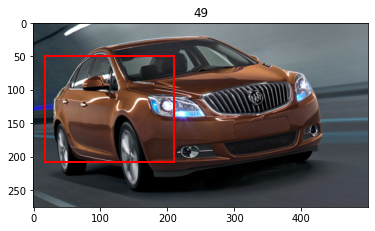

In [ ]:
fig, ax = plt.subplots(1)
ax.imshow(img)
rect = patches.Rectangle((x0,y0), wid, hght,
                          linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.title(train_class[10])
plt.show()

In [ ]:
train_class

array([ 14,   3,  91, ..., 163, 112,  17])

In [ ]:
train_class_dummy = pd.get_dummies(train_class)

In [ ]:
train_class_dummy

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8140,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8141,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8142,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_class

array([181, 103, 145, ...,  17,  38,  32])

In [ ]:
test_class_dummy = pd.get_dummies(test_class)
test_class_dummy

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8036,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8037,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8038,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8039,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
classification_history = classification_model.fit(
                          x=train_images, y=train_class_dummy, batch_size=32, 
                          epochs=10, validation_data=(test_images,test_class_dummy))

Epoch 1/10
255/255 [==============================] - 36s 105ms/step - loss: 4.8209 - accuracy: 0.0631 - val_loss: 3.5527 - val_accuracy: 0.1823
Epoch 2/10
255/255 [==============================] - 25s 97ms/step - loss: 1.9497 - accuracy: 0.5143 - val_loss: 3.0665 - val_accuracy: 0.2624
Epoch 3/10
255/255 [==============================] - 25s 97ms/step - loss: 0.8368 - accuracy: 0.7885 - val_loss: 3.2314 - val_accuracy: 0.2823
Epoch 4/10
255/255 [==============================] - 25s 98ms/step - loss: 0.4924 - accuracy: 0.8734 - val_loss: 3.5376 - val_accuracy: 0.2689
Epoch 5/10
255/255 [==============================] - 25s 98ms/step - loss: 0.4404 - accuracy: 0.8675 - val_loss: 3.6179 - val_accuracy: 0.2849
Epoch 6/10
255/255 [==============================] - 25s 98ms/step - loss: 0.4050 - accuracy: 0.8776 - val_loss: 3.9755 - val_accuracy: 0.2792
Epoch 7/10
255/255 [==============================] - 25s 98ms/step - loss: 0.3119 - accuracy: 0.9122 - val_loss: 4.0599 - val_accuracy

In [ ]:
bb_history = bb_model.fit(
                          x=train_images, y=train_bb, batch_size=32, 
                          epochs=10, validation_data=(test_images,test_bb))

Epoch 1/10
255/255 [==============================] - 45s 168ms/step - loss: 1711.0089 - IoU: 0.6126 - val_loss: 208.8126 - val_IoU: 0.7899
Epoch 2/10
255/255 [==============================] - 42s 166ms/step - loss: 155.6097 - IoU: 0.8153 - val_loss: 178.4465 - val_IoU: 0.8058
Epoch 3/10
255/255 [==============================] - 42s 165ms/step - loss: 99.1730 - IoU: 0.8489 - val_loss: 167.2039 - val_IoU: 0.8097
Epoch 4/10
255/255 [==============================] - 42s 166ms/step - loss: 72.5241 - IoU: 0.8683 - val_loss: 163.1645 - val_IoU: 0.8126
Epoch 5/10
255/255 [==============================] - 42s 166ms/step - loss: 54.0635 - IoU: 0.8859 - val_loss: 162.2915 - val_IoU: 0.8124
Epoch 6/10
255/255 [==============================] - 42s 165ms/step - loss: 45.4559 - IoU: 0.8929 - val_loss: 165.1033 - val_IoU: 0.8101
Epoch 7/10
255/255 [==============================] - 42s 165ms/step - loss: 37.1220 - IoU: 0.8976 - val_loss: 165.0084 - val_IoU: 0.8100
Epoch 8/10
255/255 [===========

In [ ]:
classification_history

In [ ]:
scores = classification_model.evaluate(test_images,test_class_dummy, verbose=1)

252/252 [==============================] - 11s 44ms/step - loss: 19.9988 - accuracy: 0.1986


In [ ]:
scores

[19.998754501342773, 0.19860713183879852]

Text(0.5, 1.0, 'Training and validation loss for classification')

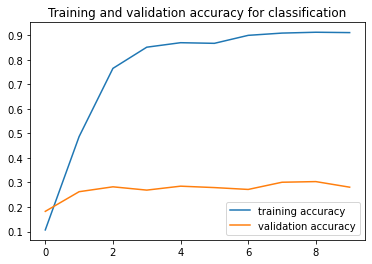

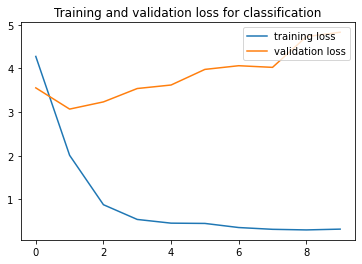

In [ ]:
accuracy      = classification_history.history['accuracy']
val_accuracy  = classification_history.history['val_accuracy']
loss     = classification_history.history['loss']
val_loss = classification_history.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  ( epochs, accuracy, label = 'training accuracy' )
plt.plot  ( epochs, val_accuracy, label = 'validation accuracy' )
plt.title ('Training and validation accuracy for classification')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  ( epochs, loss, label = 'training loss' )
plt.plot  ( epochs, val_loss, label = 'validation loss' )
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss for classification')

Text(0.5, 1.0, 'Training and validation loss for bounding box')

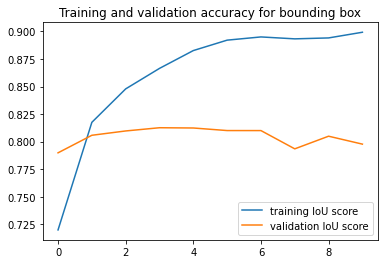

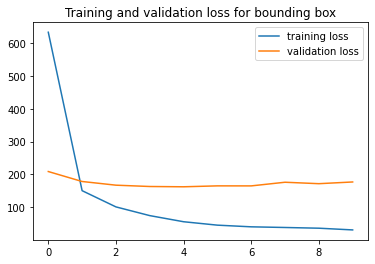

In [ ]:
IoU_score      = bb_history.history['IoU']
val_IoU_score  = bb_history.history['val_IoU']
loss     = bb_history.history['loss']
val_loss = bb_history.history['val_loss']

epochs   = range(len(IoU_score)) # Get number of epochs

plt.plot  ( epochs, IoU_score, label = 'training IoU score' )
plt.plot  ( epochs, val_IoU_score, label = 'validation IoU score' )
plt.title ('Training and validation accuracy for bounding box')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  ( epochs, loss, label = 'training loss' )
plt.plot  ( epochs, val_loss, label = 'validation loss' )
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss for bounding box')

In [ ]:
project_path

'/content/drive/My Drive/AIML/Capstone project/'

In [ ]:
json_file = classification_model.to_json()
with open(project_path+"classification_mobilenet.json", "w") as file:
   file.write(json_file)
# serialize weights to HDF5
classification_model.save_weights(project_path+"classification_mobilenet.h5")

In [ ]:
json_file = bb_model.to_json()
with open(project_path+"bb_mobilenet.json", "w") as file:
   file.write(json_file)
# serialize weights to HDF5
bb_model.save_weights(project_path+"bb_mobilenet.h5")

In [ ]:
classify_file_name = project_path+"classification_mobilenet.h5"
classification_model.save(classify_file_name)

In [ ]:
bb_file_name = project_path+"bb_mobilenet.h5"
bb_model.save(bb_file_name)

In [14]:
json_file_path = project_path+"classification_mobilenet.json"
json_file_path

'/content/drive/My Drive/AIML/Capstone project/classification_mobilenet.json'

In [17]:
json_file_class= open(json_file_path,'r').read()
classification_from_json = model_from_json(json_file_class)

In [18]:
classification_from_json.load_weights(project_path+"classification_mobilenet.h5")

In [38]:
test_file = project_path+"car_data/car_data/test/Audi V8 Sedan 1994/04657.jpg"
test_file

'/content/drive/My Drive/AIML/Capstone project/car_data/car_data/test/Audi V8 Sedan 1994/04657.jpg'

In [32]:
def process_image(file_path):
    img = cv2.UMat(cv2.imread(file_path, 1)).get()
    img_resized = cv2.resize(img,(224,224), interpolation = cv2.INTER_AREA)
    processed_img = preprocess_input(np.array(img_resized, dtype=np.float32))
    
    return processed_img

In [30]:
img = cv2.UMat(cv2.imread(test_file, 1)).get()

In [31]:
img.shape

(768, 1024, 3)

In [39]:
img = process_image(test_file)

In [40]:
img.shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


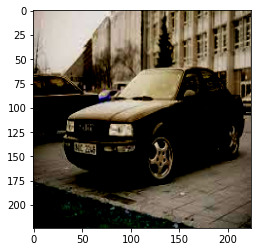

In [41]:
plt.imshow(img)
plt.show()

In [33]:
classification_from_json.predict()

ValueError: ignored

In [37]:
classification_from_json.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________